# Holdouts Evaluation - Amazon Digital Music
sample from 2014-06 until 2016-11 with 6M cold start incl. only positive rates (4 and 5 *)

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

# imports

In [2]:
import pandas as pd 
import joblib

from dataset_evaluation_utils import get_namepaths
from data_utils import load_data_print_info

from data import ImplicitData, getBucketsHoldouts
from eval_implicit import EvaluateHoldouts, EvalPrequential 
from recommenders_implicit import ISGD

from plot_utils import recall_heatmap
from data_utils.transfer_learning_scores import *

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# import plotly.offline as py
# pd.options.plotting.backend = "plotly"
# py.init_notebook_mode() # graphs charts inline (IPython).

a4_dims = (11.7, 8.27)

In [3]:
sample = 'sample_2014-06_until_2016-11+cold_start_positive_rates'


sample_year_month = [('2014-06', '%Y-%m'), ('2016-11', '%Y-%m')]
interval_type = 'S'
dump_filename ='amazon_digmusic_dump'
cold_start_buckets = 1

use_data_unique_users = False
frequent_users_thr = 0.75
to_grid_search = False
num_factors = 100
num_iter = 6
learn_rate = 0.1
regularization = 0.1
random_seed = 10

In [4]:
namepaths = get_namepaths(data_name = '_positive_rates_amazon_digitalmusic',
                          data_print_name = 'Amazon Digital Music',
                          sample_year_month = sample_year_month,
                          interval_type = interval_type,
                          dump_filename = dump_filename,
                          frequent_users_thr = frequent_users_thr,
                          cold_start_buckets = cold_start_buckets,
                          use_data_unique_users = use_data_unique_users,
                          to_grid_search = to_grid_search,
                          num_factors = num_factors,
                          num_iter = num_iter,
                          learn_rate = learn_rate,
                          regularization = regularization,
                          random_seed = random_seed,
                          model_print_name = 'ISGD')
namepaths

{'sample_str': '2014-06_until_2016-11+cold_start_fu_0.75',
 'dataset_name': 'sample_2014-06_until_2016-11+cold_start_positive_rates_amazon_digitalmusic',
 'user_col': 'user_id',
 'item_col': 'item_id',
 'output_path': 'output/amazon_digmusic_dump/',
 'data_path': 'output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_positive_rates_amazon_digitalmusic.csv',
 'use_data_unique_users': False,
 'frequent_users_path': 'output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_frequent_users_0.75.joblib',
 'cold_start_buckets': 1,
 'to_grid_search': False,
 'num_factors': 100,
 'num_iter': 6,
 'learn_rate': 0.1,
 'regularization': 0.1,
 'random_seed': 10,
 'interval_type': 'S',
 'intervals_path': 'output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_fu_0.75_semestres.joblib',
 'bucket_freq': 'semesterly',
 'buckets_path': 'output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_fu_0.75_semesterly_buckets.joblib',
 'holdouts_path': 'output/am

data.shape (80660, 4)
number of users 7353
number of items 52849
number of duplicated user-item interactions 3234

           user_id     item_id   timestamp        date
0  A1G1PWJWIVW6UR  B005OFVNTS  1401580800  2014-06-01
1   AQ4B80F0JSBNI  B002B8ZS0Q  1401580800  2014-06-01
2  A3GYWZE27QBMY7  B003RO1N98  1401580800  2014-06-01
3  A2HXYN2R7W1UQW  B000NNB2PG  1401580800  2014-06-01
4   APKXB8GFNRKEF  B000AOAA74  1401580800  2014-06-01


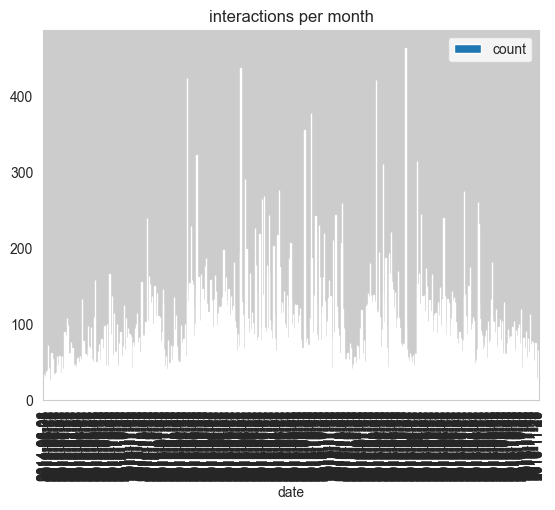

In [5]:
data = load_data_print_info(namepaths['data_path'])

In [6]:
diversity_filepath = namepaths['output_path']+'eval_files/'

# read rec list for buck 0 holdout 0

In [7]:
rec_lists_b0_h0 = joblib.load(diversity_filepath+'rec_lists_b0_h0.joblib')
print(rec_lists_b0_h0[0])
print('number of rec lists:', len(rec_lists_b0_h0))

[['B001PZ06PS' '0.5036084630168064']
 ['B001386NZE' '0.504954758011992']
 ['B00PJU8VFM' '0.5300628103145297']
 ['B00PBW27VW' '0.5339717351154083']
 ['B00RDEZFN8' '0.5367134409011927']
 ['B009G3S0F4' '0.5513772036287757']
 ['B00T6LGM8I' '0.5687287247543856']
 ['B001IOX1XU' '0.5718044552327285']
 ['B00HB3K55O' '0.5758350167539408']
 ['B00138C98E' '0.5761612550263624']
 ['B00658KG9G' '0.5805775107869356']
 ['B0012QP330' '0.5886001586757581']
 ['B00FZ11C0G' '0.5955553326482207']
 ['B00C3JARCC' '0.5974429158090512']
 ['B00IGIZUGW' '0.5982248029754619']
 ['B00AI3KG0I' '0.6026388892645813']
 ['B00SYTTBMC' '0.6076058554699273']
 ['B00KJJS6HQ' '0.6084093523470404']
 ['B001L0TTS2' '0.6134002633706033']
 ['B00PJU9YSA' '0.6139947052274874']]
number of rec lists: 3382


In [106]:
set([l==[] for l in rec_lists_b0_h0]) # no empty rec list (at a 1st glance)

{False}

# Convert it in dataframe

In [8]:
rl_col = ['bucket_idx','holdout_idx','reclist_idx', 'item_id', 'score']
rec_list_df = pd.DataFrame(columns=rl_col)

for i, rl in enumerate(rec_lists_b0_h0):
    _ = pd.DataFrame(rec_lists_b0_h0[i], columns = ['item_id', 'score'])
    _[rl_col[0]] = 0
    _[rl_col[1]] = 0
    _[rl_col[2]] = i
    # print(_)

    rec_list_df = pd.concat([rec_list_df, _])

rec_list_df

,bucket_idx,holdout_idx,reclist_idx,item_id,score
0,0,0,0,B001PZ06PS,0.5036084630168064
1,0,0,0,B001386NZE,0.504954758011992
2,0,0,0,B00PJU8VFM,0.5300628103145297
3,0,0,0,B00PBW27VW,0.5339717351154083
4,0,0,0,B00RDEZFN8,0.5367134409011927
...,...,...,...,...,...
15,0,0,3381,B002KY6G9I,0.5703635509484708
16,0,0,3381,B00QG30G68,0.5734080374965371
17,0,0,3381,B00SYTMDS6,0.5820801992550826
18,0,0,3381,B00HINPANE,0.5833121376304718


# read item side information

In [9]:
div_col = 'n_brand'
meta_dm = pd.read_csv(namepaths['output_path']+'meta_amazon_digitalmusic.csv')
meta_dm.columns = ['item_id', div_col, 'brand']
meta_dm

,item_id,n_brand,brand
0,0001377647,1,John Michael Talbot
1,0001388703,1,Keith Green
2,0001526146,1,Dallas Holm
3,0001527134,1,Don Francisco
4,0001529145,1,Second Chapter of Acts
...,...,...,...
49228,B01HH68B96,1,THE OUTLAWS
49229,B01HH7D5KU,1,FUTURE
49230,B01HHGQXI2,1,Tori Amos
49231,B01HHRIKKK,1,EXO


# merge rec list with item side info

In [11]:
meta_rec = pd.merge(rec_list_df, 
                    meta_dm, 
                    how='left')
meta_rec

,bucket_idx,holdout_idx,reclist_idx,item_id,score,n_brand,brand
0,0,0,0,B001PZ06PS,0.5036084630168064,NaN,NaN
1,0,0,0,B001386NZE,0.504954758011992,NaN,NaN
2,0,0,0,B00PJU8VFM,0.5300628103145297,NaN,NaN
3,0,0,0,B00PBW27VW,0.5339717351154083,NaN,NaN
4,0,0,0,B00RDEZFN8,0.5367134409011927,NaN,NaN
...,...,...,...,...,...,...,...
67635,0,0,3381,B002KY6G9I,0.5703635509484708,NaN,NaN
67636,0,0,3381,B00QG30G68,0.5734080374965371,NaN,NaN
67637,0,0,3381,B00SYTMDS6,0.5820801992550826,NaN,NaN
67638,0,0,3381,B00HINPANE,0.5833121376304718,NaN,NaN


In [12]:
meta_rec.isna().any()

bucket_idx     False
holdout_idx    False
reclist_idx    False
item_id        False
score          False
n_brand         True
brand           True
dtype: bool

In [13]:
meta_dm[meta_dm.brand=='0']

,item_id,n_brand,brand


## fill in NA values

In [14]:
meta_rec.loc[meta_rec[namepaths['item_col']].isna(), 'item_id'] = '0'
meta_rec.loc[meta_rec[div_col].isna(), div_col] = 0
meta_rec.loc[meta_rec.brand.isna(), 'brand'] = '0'

# calculate rec list diversity

In [31]:
reclist_div = meta_rec[['bucket_idx','holdout_idx','reclist_idx',div_col]]\
                .groupby(['bucket_idx','holdout_idx','reclist_idx'])\
                    .sum().reset_index()

rec_div_col = 'intra_list_n_brands'
reclist_div.columns = ['bucket_idx','holdout_idx','reclist_idx', rec_div_col]
reclist_div

,bucket_idx,holdout_idx,reclist_idx,intra_list_n_brands
0,0,0,0,2.0
1,0,0,1,0.0
2,0,0,2,1.0
3,0,0,3,3.0
4,0,0,4,0.0
...,...,...,...,...
3377,0,0,3377,2.0
3378,0,0,3378,0.0
3379,0,0,3379,0.0
3380,0,0,3380,1.0


In [16]:
meta_rec[meta_rec.reclist_idx==0]

,bucket_idx,holdout_idx,reclist_idx,item_id,score,n_brand,brand
0,0,0,0,B001PZ06PS,0.5036084630168064,0.0,0
1,0,0,0,B001386NZE,0.504954758011992,0.0,0
2,0,0,0,B00PJU8VFM,0.5300628103145297,0.0,0
3,0,0,0,B00PBW27VW,0.5339717351154083,0.0,0
4,0,0,0,B00RDEZFN8,0.5367134409011927,0.0,0
5,0,0,0,B009G3S0F4,0.5513772036287757,0.0,0
6,0,0,0,B00T6LGM8I,0.5687287247543856,0.0,0
7,0,0,0,B001IOX1XU,0.5718044552327285,0.0,0
8,0,0,0,B00HB3K55O,0.5758350167539408,0.0,0
9,0,0,0,B00138C98E,0.5761612550263624,0.0,0


# Read user profiles at bucket 0

In [17]:
model_data_b0 = joblib.load(diversity_filepath+'model_data_b0.joblib')
model_data_b0

In [109]:
print(model_data_b0.userlist[:3])
print(len(model_data_b0.userlist))
print(model_data_b0.itemlist[:3])
print(len(model_data_b0.itemlist))

['A1G1PWJWIVW6UR', 'AQ4B80F0JSBNI', 'A3GYWZE27QBMY7']
25278
['B005OFVNTS', 'B002B8ZS0Q', 'B003RO1N98']
25278


In [110]:
print(model_data_b0.userset[:3])
print(len(model_data_b0.userset))
print(model_data_b0.itemset[:3])
print(len(model_data_b0.itemset))

['A1G1PWJWIVW6UR' 'AQ4B80F0JSBNI' 'A3GYWZE27QBMY7']
5885
['B005OFVNTS' 'B002B8ZS0Q' 'B003RO1N98']
18863


In [112]:
pd.Series(model_data_b0.userlist).value_counts()

A1BYA1IVKO7U79    279
A1Q0BU32CVOLRA    222
A237E0FTADYM58    194
AIZWM3J1HG027     175
A2X7VV7HOAAJRW    160
                 ... 
A2PUHH4ET0N0JE      1
A2X6FIMP5EEMOW      1
A2EOY7FZX76YKP      1
A27U1QIOY2JBBV      1
AJ6I35OWXX94P       1
Length: 5885, dtype: int64

In [113]:
pd.Series(model_data_b0.userset).value_counts()

A1E4YQVLZIM4W     1
A2QEZUN14N9K5M    1
A3NGBEYY9T1A8B    1
A1XNZDOWDENTTM    1
A1MYLPCML8V4KT    1
                 ..
A1A5DMHT3Z21ML    1
A3P7NBDAP89CBC    1
A2M6Q3JIHPYZLK    1
A3IY9HIAMJQ7HL    1
AR8O7SVSEUI9Z     1
Length: 5885, dtype: int64

In [ ]:
model_data_b0.userlist[:3]

In [19]:
print(model_data_b0.GetUserInternalId('A1G1PWJWIVW6UR'))
print(model_data_b0.GetUserItems(0))

0
[0, 4357, 11748, 13311, 13410, 4209]


In [114]:
user_div_col = 'user_n_brands'

user_profile_cols = ['bucket_idx', 'user_id', 'n_seen_items', user_div_col]
user_profile_div = pd.DataFrame(columns=user_profile_cols)

for u in (model_data_b0.userset):
    # df (bucket_idx, u, n_seen_items, sum=diversity)
    user_profile = model_data_b0.GetUserItems(u, internal=False)
    div = meta_dm.loc[meta_dm['item_id'].isin(user_profile), 'n_brand'].sum()
    
    user_profile_div.loc[len(user_profile_div),:] = [0, u, len(user_profile), div]

user_profile_div

,bucket_idx,user_id,n_seen_items,user_n_brands
0,0,A1G1PWJWIVW6UR,6,0
1,0,AQ4B80F0JSBNI,60,49
2,0,A3GYWZE27QBMY7,25,0
3,0,A2HXYN2R7W1UQW,24,18
4,0,APKXB8GFNRKEF,4,3
...,...,...,...,...
5880,0,AOYBP47YAZ192,1,0
5881,0,A3ETTRL6MY546F,1,0
5882,0,A2Z9HDTNB6PJHX,1,0
5883,0,A24T6NPYAEJOJW,1,0


<AxesSubplot:ylabel='Frequency'>

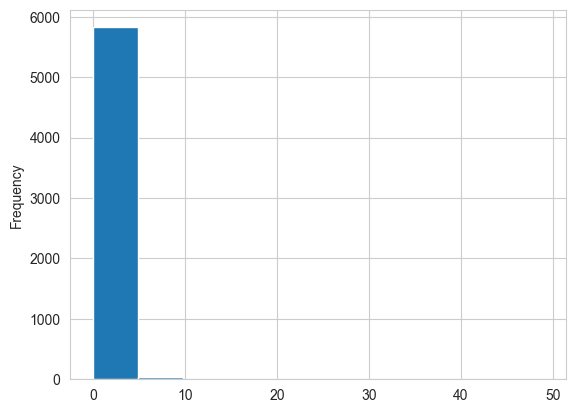

In [115]:
user_profile_div.user_n_brands.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

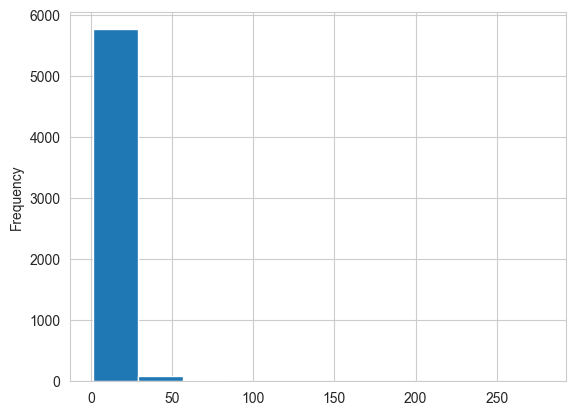

In [116]:
user_profile_div.n_seen_items.plot(kind='hist')

In [117]:
user_profile_div.n_seen_items.value_counts()

1     3057
2      765
3      487
4      319
5      248
      ... 
60       1
57       1
56       1
55       1
40       1
Name: n_seen_items, Length: 77, dtype: int64

# get user list and add to reclist_diversity

In [118]:
reclist_div

,bucket_idx,holdout_idx,reclist_idx,intra_list_n_brands,user_id
0,0,0,0,2.0,A3KYAT2VDRR82T
1,0,0,1,0.0,A3G05IEEQP0LHM
2,0,0,2,1.0,AHPL6R4U5WNQ4
3,0,0,3,3.0,ACCSZ928M4MWW
4,0,0,4,0.0,AO57NG302ZAQ4
...,...,...,...,...,...
3377,0,0,3377,2.0,A2FFZUNFXJRQO7
3378,0,0,3378,0.0,A382OWESG9UBOU
3379,0,0,3379,0.0,A2NOPEELVIMMF4
3380,0,0,3380,1.0,A9ZLL6NL7HN0P


In [119]:
holdouts = joblib.load(namepaths['output_path']+'sample_2014-06_until_2016-11+cold_start_positive_rates_fu_0.75_semesterly_holdouts.joblib')
holdouts

In [120]:
for j, hd in enumerate(holdouts[:1]):
    print(hd.userlist)

0       A3KYAT2VDRR82T
1       A3G05IEEQP0LHM
2        AHPL6R4U5WNQ4
3        ACCSZ928M4MWW
4        AO57NG302ZAQ4
             ...      
3377    A2FFZUNFXJRQO7
3378    A382OWESG9UBOU
3379    A2NOPEELVIMMF4
3380     A9ZLL6NL7HN0P
3381    A1EX0000XTYIWQ
Name: user_id, Length: 3382, dtype: object


In [121]:
reclist_div['user_id'] = holdouts[0].userlist
reclist_div

,bucket_idx,holdout_idx,reclist_idx,intra_list_n_brands,user_id
0,0,0,0,2.0,A3KYAT2VDRR82T
1,0,0,1,0.0,A3G05IEEQP0LHM
2,0,0,2,1.0,AHPL6R4U5WNQ4
3,0,0,3,3.0,ACCSZ928M4MWW
4,0,0,4,0.0,AO57NG302ZAQ4
...,...,...,...,...,...
3377,0,0,3377,2.0,A2FFZUNFXJRQO7
3378,0,0,3378,0.0,A382OWESG9UBOU
3379,0,0,3379,0.0,A2NOPEELVIMMF4
3380,0,0,3380,1.0,A9ZLL6NL7HN0P


# group results

In [122]:
user_profile_div

,bucket_idx,user_id,n_seen_items,user_n_brands
0,0,A1G1PWJWIVW6UR,6,0
1,0,AQ4B80F0JSBNI,60,49
2,0,A3GYWZE27QBMY7,25,0
3,0,A2HXYN2R7W1UQW,24,18
4,0,APKXB8GFNRKEF,4,3
...,...,...,...,...
5880,0,AOYBP47YAZ192,1,0
5881,0,A3ETTRL6MY546F,1,0
5882,0,A2Z9HDTNB6PJHX,1,0
5883,0,A24T6NPYAEJOJW,1,0


In [123]:
reclist_div.user_id.value_counts()

A1E4YQVLZIM4W     1
A2QEZUN14N9K5M    1
A1DVFJRY2GDWC6    1
A1ZM2ASMFBZTZR    1
A1C7Y31S5QXNTR    1
                 ..
A1FD0QVM57YWQE    1
AEDE8DTYD94BS     1
A1TPKBOBV0O84Z    1
A35HJUJEWTHYH     1
AR8O7SVSEUI9Z     1
Name: user_id, Length: 3382, dtype: int64

In [124]:
user_profile_div.user_id.value_counts()

A1E4YQVLZIM4W     1
A2QEZUN14N9K5M    1
A3NGBEYY9T1A8B    1
A1XNZDOWDENTTM    1
A1MYLPCML8V4KT    1
                 ..
A1A5DMHT3Z21ML    1
A3P7NBDAP89CBC    1
A2M6Q3JIHPYZLK    1
A3IY9HIAMJQ7HL    1
AR8O7SVSEUI9Z     1
Name: user_id, Length: 5885, dtype: int64

In [126]:
diversity_df = pd.merge(reclist_div[['user_id','intra_list_n_brands']],
                        user_profile_div[['user_id','n_seen_items','user_n_brands']],
                        how='left')

diversity_df

,user_id,intra_list_n_brands,n_seen_items,user_n_brands
0,A3KYAT2VDRR82T,2.0,4,0
1,A3G05IEEQP0LHM,0.0,1,0
2,AHPL6R4U5WNQ4,1.0,4,0
3,ACCSZ928M4MWW,3.0,2,0
4,AO57NG302ZAQ4,0.0,3,0
...,...,...,...,...
3377,A2FFZUNFXJRQO7,2.0,19,0
3378,A382OWESG9UBOU,0.0,9,0
3379,A2NOPEELVIMMF4,0.0,49,0
3380,A9ZLL6NL7HN0P,1.0,1,0


In [144]:
diversity_df['n_seen_items_binned'] = pd.cut(diversity_df.n_seen_items, 4,  labels=[.25, .5, .75, 1.])
diversity_df

,user_id,intra_list_n_brands,n_seen_items,user_n_brands,n_seen_items_binned
0,A3KYAT2VDRR82T,2.0,4,0,0.25
1,A3G05IEEQP0LHM,0.0,1,0,0.25
2,AHPL6R4U5WNQ4,1.0,4,0,0.25
3,ACCSZ928M4MWW,3.0,2,0,0.25
4,AO57NG302ZAQ4,0.0,3,0,0.25
...,...,...,...,...,...
3377,A2FFZUNFXJRQO7,2.0,19,0,0.25
3378,A382OWESG9UBOU,0.0,9,0,0.25
3379,A2NOPEELVIMMF4,0.0,49,0,0.25
3380,A9ZLL6NL7HN0P,1.0,1,0,0.25


In [148]:
avg_rec_div_col = 'avg_intra_list_n_brands'
avg_intra_list_div_per_bin = diversity_df[['n_seen_items_binned', 'intra_list_n_brands']].groupby('n_seen_items_binned').mean().reset_index()
avg_intra_list_div_per_bin.columns = ['n_seen_items_binned', avg_rec_div_col]
avg_intra_list_div_per_bin

,n_seen_items_binned,avg_intra_list_n_brands
0,0.25,1.148214
1,0.50,1.529412
2,0.75,2.000000
3,1.00,0.500000


In [150]:
diversity_df = pd.merge(diversity_df, avg_intra_list_div_per_bin)
diversity_df

,user_id,intra_list_n_brands,n_seen_items,user_n_brands,n_seen_items_binned,avg_intra_list_n_brands
0,A3KYAT2VDRR82T,2.0,4,0,0.25,1.148214
1,A3G05IEEQP0LHM,0.0,1,0,0.25,1.148214
2,AHPL6R4U5WNQ4,1.0,4,0,0.25,1.148214
3,ACCSZ928M4MWW,3.0,2,0,0.25,1.148214
4,AO57NG302ZAQ4,0.0,3,0,0.25,1.148214
...,...,...,...,...,...,...
3377,A2X7VV7HOAAJRW,3.0,160,2,0.75,2.000000
3378,AIZWM3J1HG027,2.0,175,3,0.75,2.000000
3379,A237E0FTADYM58,1.0,194,0,0.75,2.000000
3380,A1BYA1IVKO7U79,1.0,279,2,1.00,0.500000


<AxesSubplot:xlabel='n_seen_items_binned', ylabel='avg_intra_list_n_brands'>

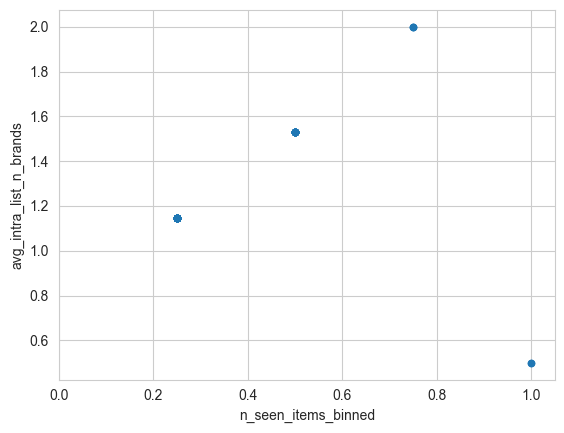

In [160]:
diversity_df[['n_seen_items_binned', avg_rec_div_col]].plot(x='n_seen_items_binned',
                                                            y=avg_rec_div_col,
                                                            kind='scatter',
                                                            xlim=[0,1.05])

<AxesSubplot:xlabel='n_seen_items', ylabel='user_n_brands'>

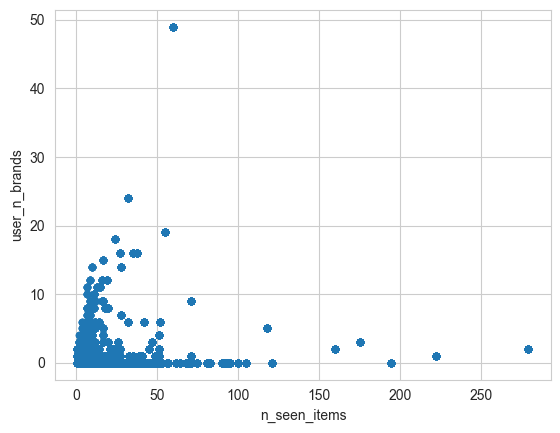

In [ ]:
#.set_index('user_id')
user_profile_div[['user_id','n_seen_items','user_n_brands']].plot(x='n_seen_items',
                                                                  y='user_n_brands',
                                                                  kind='scatter')

In [ ]:
# x axis -> groups n_seen_items

# bin rec list according to the respective user n_seen_items

# y axix -> avg top 20 div

# scatter points of users

In [ ]:
# optimise to read holdouts and buckets


# optimise to read holdouts and buckets

CPU times: total: 0 ns
Wall time: 0 ns
load model's data @bucket0
calculate the average intra list diversity per group
calculate the average intra list diversity per group
calculate the average intra list diversity per group
calculate the average intra list diversity per group
load model's data @bucket1
calculate the average intra list diversity per group
calculate the average intra list diversity per group
calculate the average intra list diversity per group
calculate the average intra list diversity per group
load model's data @bucket2
calculate the average intra list diversity per group
calculate the average intra list diversity per group
calculate the average intra list diversity per group
calculate the average intra list diversity per group
load model's data @bucket3
calculate the average intra list diversity per group
calculate the average intra list diversity per group
calculate the average intra list diversity per group
calculate the average intra list diversity per group


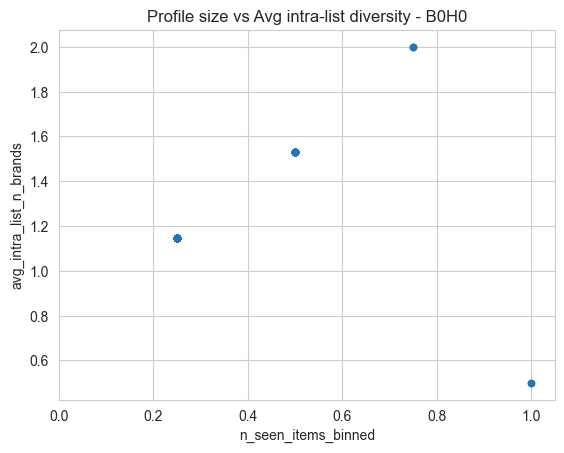

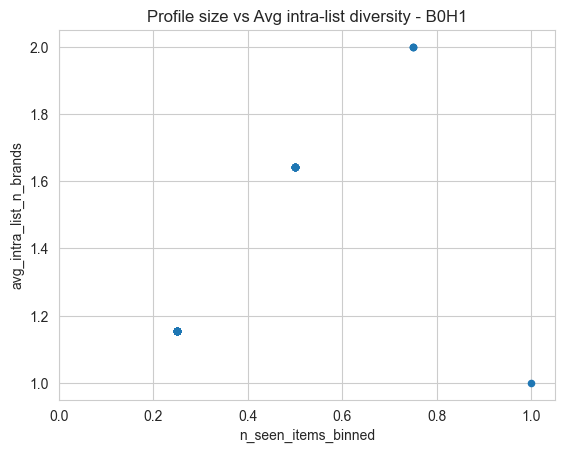

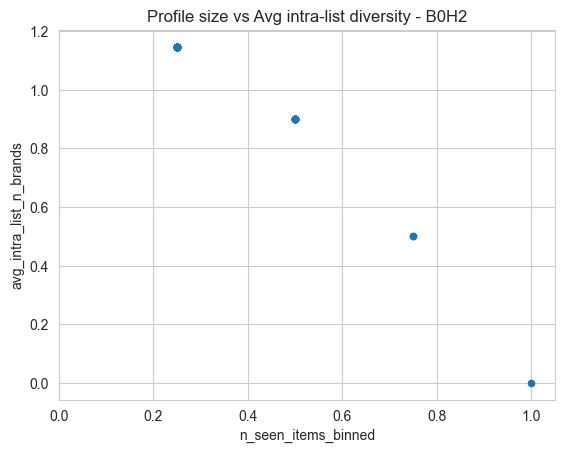

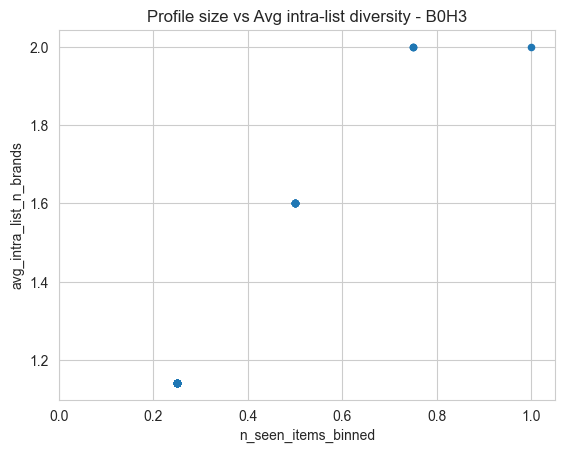

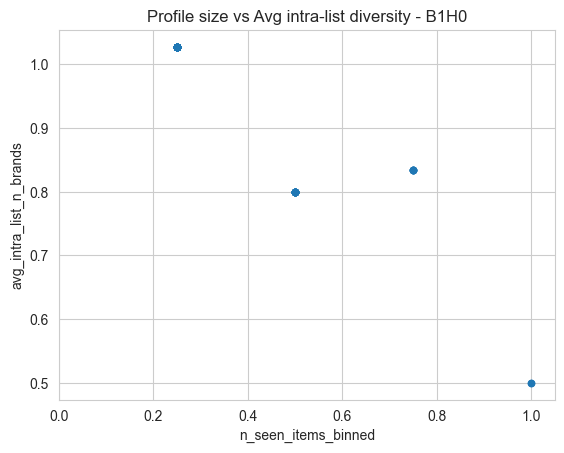

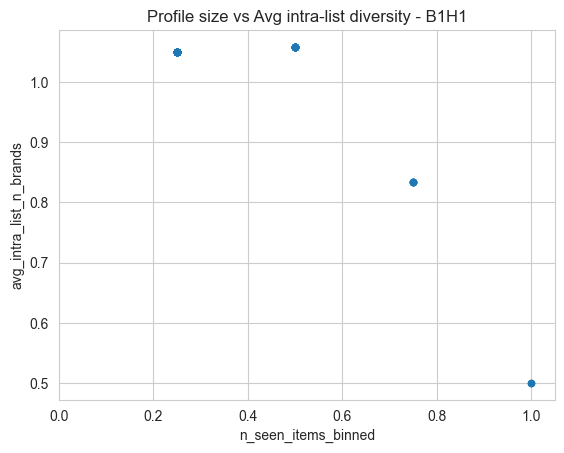

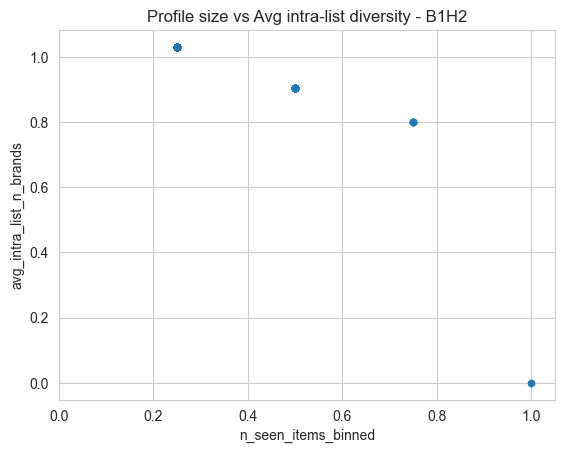

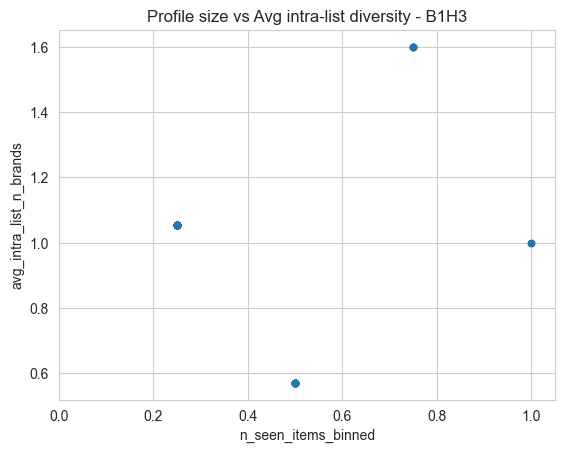

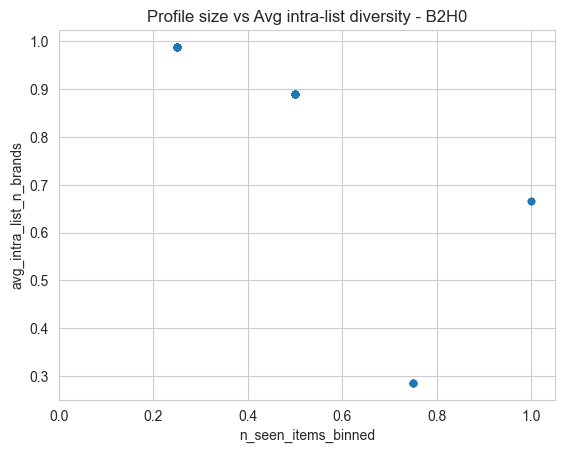

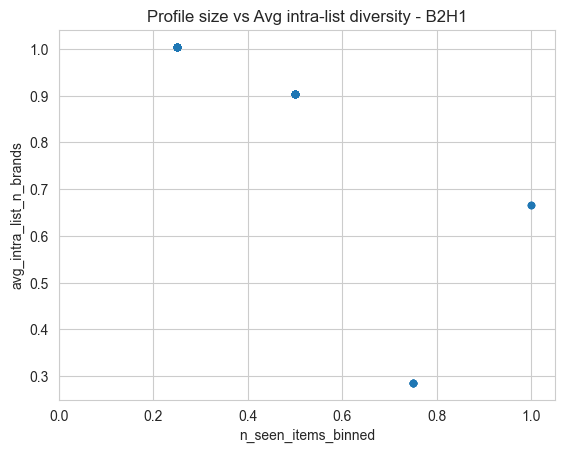

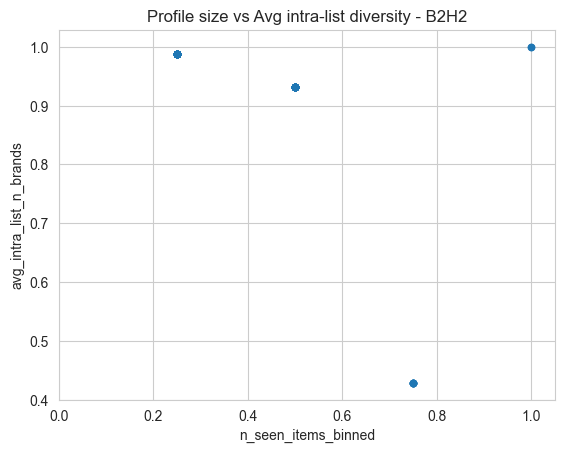

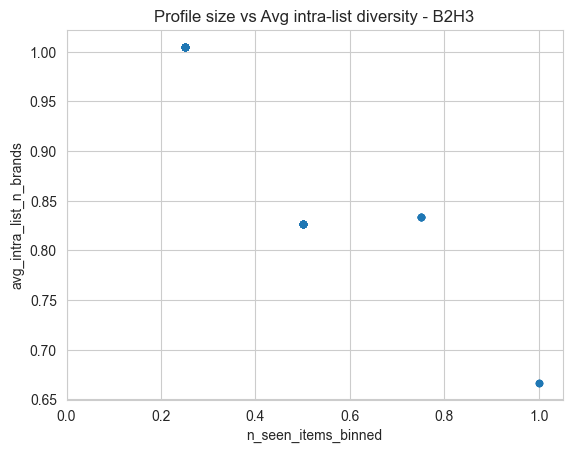

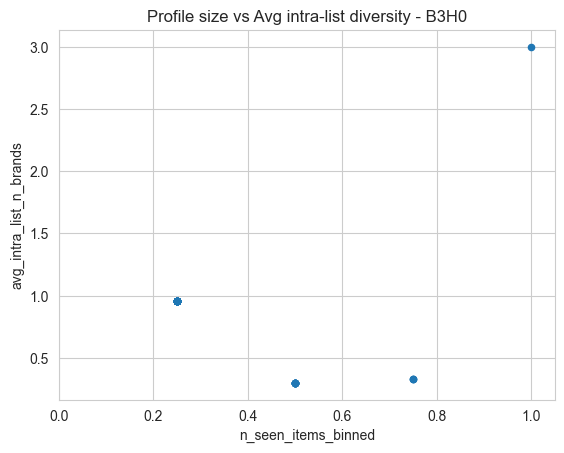

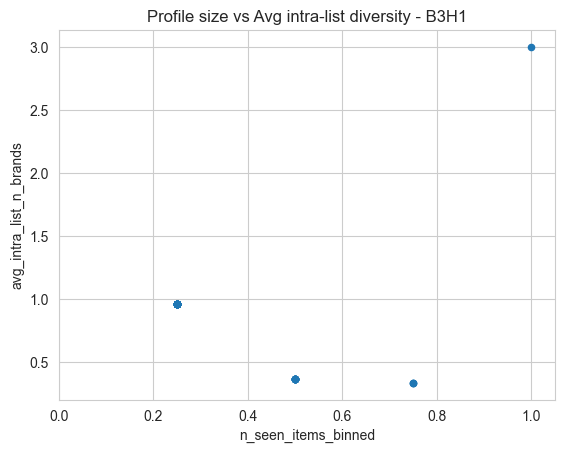

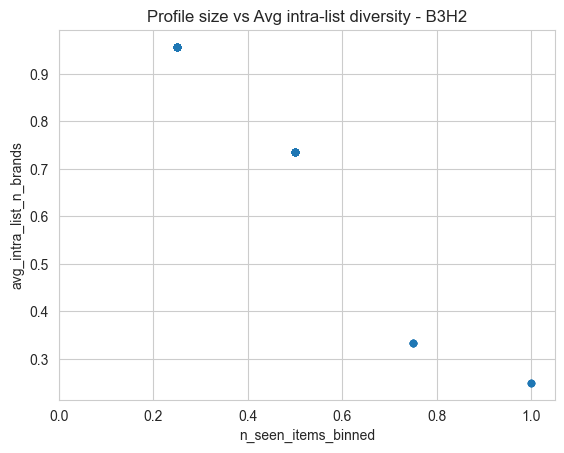

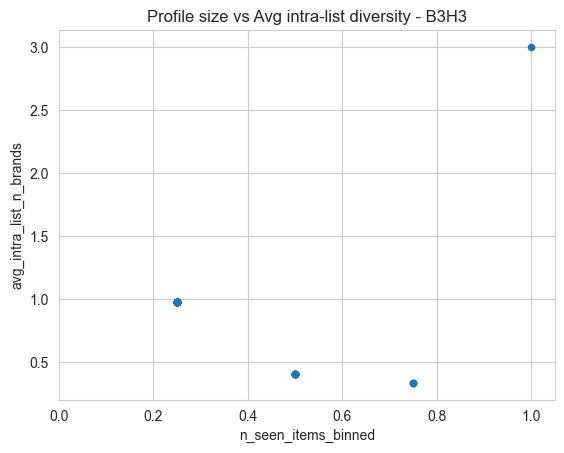

In [8]:
%time

diversity_filepath = namepaths['output_path']+'eval_files/'
sample_str = 'sample_2014-06_until_2016-11+cold_start_positive_rates_fu_0.75_semesterly'


div_col = 'n_brand'
meta_dm = pd.read_csv(namepaths['output_path']+'meta_amazon_digitalmusic.csv')
meta_dm.columns = ['item_id', div_col, 'brand']

# 'bucket_idx','holdout_idx',

# print('load all holdouts')
holdouts = joblib.load(namepaths['output_path']+sample_str+'_holdouts.joblib')

for bi in range(len(holdouts)):

    print('load model\'s data @bucket'+str(bi))
    model_data = joblib.load(diversity_filepath+'model_data_b'+str(bi)+'.joblib')


    #print('calculate user profile diversity and length')
    user_div_col = 'user_n_brands'
    user_profile_cols = ['user_id', 'n_seen_items', user_div_col]
    user_profile_div = pd.DataFrame(columns=user_profile_cols)
    for u in (model_data.userset):
        # df (u, n_seen_items, sum=diversity)
        user_profile = model_data.GetUserItems(u, internal=False)
        div = meta_dm.loc[meta_dm['item_id'].isin(user_profile), div_col].sum()
        user_profile_div.loc[len(user_profile_div),:] = [u, len(user_profile), div]



    for hi in range(len(holdouts)):
        
        # print('load rec lists @holdout '+str(hi))
        rec_lists = joblib.load(diversity_filepath+'rec_lists_b'+str(bi)+'_h'+str(hi)+'.joblib')
        # print('number of rec lists:', len(rec_lists))


        # print('convert recommendation lists file to dataframe')
        rl_col = ['reclist_idx', 'item_id', 'score']
        reclists_df = pd.DataFrame(columns=rl_col)
        for i, rl in enumerate(rec_lists):
            _ = pd.DataFrame(rl, columns = ['item_id', 'score'])
            _[rl_col[0]] = i
            reclists_df = pd.concat([reclists_df, _])   


        # print('add side info to rec list frame')
        meta_reclist = pd.merge(reclists_df, 
                            meta_dm, 
                            how='left')
        # print('fill in Na values')
        meta_reclist.loc[meta_reclist['item_id'].isna(), 'item_id'] = '0'
        meta_reclist.loc[meta_reclist[div_col].isna(), div_col] = 0
        meta_reclist.loc[meta_reclist.brand.isna(), 'brand'] = '0'


        # print('calculate the diversity for each recommendation list')
        reclist_div = meta_reclist[['reclist_idx',div_col]]\
                .groupby(['reclist_idx'])\
                    .sum().reset_index()

        rec_div_col = 'intra_list_n_brands'
        reclist_div.columns = ['reclist_idx', rec_div_col]
        # print('add user id to reclist_div')
        reclist_div['user_id'] = holdouts[hi].userlist

        
        # print('group results per quartiles')
        org_bin_col = 'n_seen_items'
        bin_col = org_bin_col+'_binned'

        diversity_df = pd.merge(reclist_div[['user_id', rec_div_col]],
                                user_profile_div[['user_id','n_seen_items', user_div_col]],
                                how='left')
        diversity_df[bin_col] = pd.cut(diversity_df[org_bin_col], 4,  labels=[.25, .5, .75, 1.])
        
        print('calculate the average intra list diversity per group')
        avg_rec_div_col = 'avg_'+rec_div_col
        avg_intra_list_div_per_bin = diversity_df[[bin_col, rec_div_col]].groupby(bin_col).mean().reset_index()
        avg_intra_list_div_per_bin.columns = [bin_col, avg_rec_div_col]
        
        diversity_df = pd.merge(diversity_df, avg_intra_list_div_per_bin)
        

        diversity_df[[bin_col, avg_rec_div_col]].plot(x=bin_col,
                                                      y=avg_rec_div_col,
                                                      kind='scatter',
                                                      xlim=[0,1.05],
                                                      title='Profile size vs Avg intra-list diversity - B'+str(bi)+'H'+str(hi));
        

